In [135]:
  
from keras.layers import *
from keras import Model
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras import regularizers
import numpy as np
import keras, time
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


In [136]:
class CoLa(Layer):
    def __init__(self, nAdded, **kwargs):
        # Set the number of added combinations
        self.nAdded = nAdded
        super(CoLa, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weight for the linear combination
        self.combination = self.add_weight(name='combination',
                    shape=(input_shape[2], self.nAdded),
                    initializer='uniform',
                    trainable=True)
        super(CoLa, self).build(input_shape)

    def call(self, x):
        # Generate combinations and return input with appended with combinations
        combined = K.dot(x, self.combination)
        return K.concatenate([x, combined], axis=2)

    def compute_output_shape(self, input_shape):
        self.out_shape = (input_shape[0], 
                    input_shape[1], 
                    input_shape[2] + self.nAdded)
        return self.out_shape

    def get_config(self):
        # Store nAdded value for loading saved models later
        base_config = super(CoLa, self).get_config()
        base_config['nAdded'] = self.nAdded
        return base_config


In [137]:
class LoLa(Layer):
    """Lorentz Layer adapted from arXiv:1707.08966
    From an input of 4 vectors generate some physical quantities that serve as
    input to a classifiction network
    """
    def __init__(self, **kwargs):
        super(LoLa, self).__init__(**kwargs)

    def build(self, input_shape):
        initializer = keras.initializers.TruncatedNormal(mean=0., stddev=0.1)
        metric = keras.initializers.Constant(value=[[1., -1., -1., -1.]])
        # Trainable metric for 4-vector multiplication
        self.metric = self.add_weight(name='metric',
                    shape=(1, 4),
                    initializer=metric,
                    trainable=True)

        # Weights for the linear combination of energies
        self.energyCombination = self.add_weight(name='energyCombination',
                    shape=(input_shape[-1], input_shape[-1]),
                    initializer=initializer,
                    trainable=True)
        
        # Weights for the linear combinations of distances
        self.distanceCombination = self.add_weight(name='distanceCombination',
                    shape=(input_shape[2], 4),
                    initializer=initializer,
                    trainable=True)
        super(LoLa, self).build(input_shape)

    def call(self, x):
        def getDistanceMatrix(x):
            """Input:
            x, (batchsize, features, nConst) - array of vectors
            Returns:
            dists, (batchsize, nConst, nConst) - distance array for every jet
            """
            part1 = -2 * K.batch_dot(x, K.permute_dimensions(x, (0, 2, 1)))
            part2 = K.permute_dimensions(K.expand_dims(K.sum(x**2, axis=2)), (0, 2, 1))
            part3 = K.expand_dims(K.sum(x**2, axis=2))
            dists = part1 + part2 + part3
            return dists

        # Get mass of each 4-momentum
        mass = K.dot(self.metric, K.square(x))
        mass = K.permute_dimensions(mass, (1, 0, 2))

        # Get pT of each 4-momentum
        pT = x[:, 1, :] ** 2 + x[:, 2, :] ** 2
        pT = K.sqrt(K.reshape(pT, (K.shape(pT)[0], 1, K.shape(pT)[1])))
        
        # Get a learnable linear combination of the energies of all constituents
        energies = K.dot(x[:, 0, :], self.energyCombination)
        energies = K.reshape(energies, 
                            (K.shape(energies)[0], 1, K.shape(energies)[1]))
 
        # Get the distance matrix and do some linear combination
        dists_3 = getDistanceMatrix(
                            K.permute_dimensions(x[:, 1:, :], (0, 2, 1)))
        dists_0 = getDistanceMatrix(
                            K.permute_dimensions(x[:, 0, None, :], (0, 2, 1)))
        dists = dists_0 - dists_3
        
        dists = K.dot(dists, self.distanceCombination)
        dists = K.permute_dimensions(dists, (0, 2, 1))

        return K.concatenate([mass, pT, energies, dists], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 7, input_shape[2])

In [138]:
class LoLaClassifier():
    def __init__(self, nConstituents, nAdded, tag=0):
        self.tag = tag
        self.model = self._genNetwork(nConstituents, nAdded)
        pass

    def _genNetwork(self, nConstituents, nAdded):
        input = Input((4, nConstituents))
        layer = input

        # Combination layer adds nAdded linear combinations of vectors
        layer = CoLa(nAdded=nAdded, name='cola')(layer)
        # LoLa replaces the 4 vectors by physically more meaningful vectors
        layer = LoLa(name='lola')(layer) 

        # Connect to a fully connected network for classification
        layer = Flatten()(layer)
        layer = Dense(100, activation='relu')(layer)
        layer = Dense(50, activation='relu')(layer)
        layer = Dense(10, activation='relu')(layer)
        layer = Dense(2, activation='softmax')(layer)
        
        model = keras.Model(input, layer)
        return model

In [139]:
def loadData(filenames, nJets=slice(200000), nConstituents=10):
    with h5py.File(filenames[0], 'r') as f:
        bg_momenta = f['momenta'][nJets, :nConstituents, :]
        bg_labels = np.zeros(len(bg_momenta))
    
    with h5py.File(filenames[1], 'r') as f:
        sig_momenta = f['momenta'][nJets, :nConstituents, :]
        sig_labels = np.ones(len(sig_momenta))

    momenta = np.append(bg_momenta, sig_momenta, axis=0)

    labels = keras.utils.to_categorical(
            np.append(bg_labels, sig_labels), 2)
    indices = np.random.permutation(len(labels))
    print(momenta.shape, labels.shape)
    return momenta[indices], labels[indices]


In [140]:
def loadJetMomenta(filenames, nJets=slice(200000), nConstituents=10):
    """Load jet momenta from given files
    Input:
     filenames: (2,) - list containing path to bg and sig jet momenta
     nJets: slice - indices for loading data
     nConstituents: int giving number of leading pT constituents per jet
    Returns:
     momenta: (nJets, 4, nConstituents) shuffled array of jet momenta
     labels: (nJets, 2) one hot encoded labels for momenta
    """
    print("Loading by given slice {}".format(nJets))
    # Load momenta from bg_file
    with h5py.File(filenames[0], 'r') as f:
        if f['momenta'].shape[-1] == 4:
            bg_momenta = f['momenta'][nJets, :nConstituents, :]
        elif f['momenta'].shape[-2] == 4:
            bg_momenta = f['momenta'][nJets, :, :nConstituents]
            bg_momenta = np.transpose(bg_momenta, (0, 2, 1))
        else:
            print("Momenta cannot be loaded")
            exit()
        bg_labels = np.zeros(len(bg_momenta))
        print("\n{} bg jets loaded from {}".format(
            len(bg_labels), filenames[0]))

    # Load momenta from sig_file
    with h5py.File(filenames[1], 'r') as f:
        if f['momenta'].shape[-1] == 4:
            sig_momenta = f['momenta'][nJets, :nConstituents, :]
        elif f['momenta'].shape[-2] == 4:
            sig_momenta = f['momenta'][nJets, :, :nConstituents]
            sig_momenta = np.transpose(sig_momenta, (0, 2, 1))
        else:
            print("Momenta cannot be loaded")
            exit()
            
        sig_labels = np.ones(len(sig_momenta))
        print("{} sig jets loaded from {}\n\n".format(
            len(sig_labels), filenames[1]))


    # Connect momenta, shuffle and return them with corresponding labels
    momenta = np.append(bg_momenta, sig_momenta, axis=0)
    labels = keras.utils.to_categorical(
            np.append(bg_labels, sig_labels), 2)
    indices = np.random.permutation(len(labels))
    print(momenta.shape, labels.shape)
    return momenta[indices], labels[indices]


In [141]:

def loadJetMomentaBenchmark(filename, nConstituents=10, start=None, end=100000):
    """Load jet momenta from top tagging dataset as used in arXiv:1902.09914
    Input:
     filename: str, path to file
     nConstituents: int, number of constituents loaded for each jet
     start: int, index from which to start select events
     end: int, index up to which select events
    Returns:
     momenta: (nJets, 4, nConstituents), array with 4 momenta of jet constituents
     labels: (nJets, 2), one-hot encoded labels for jets
    """

    with pandas.HDFStore(filename, 'r') as store:
        print("Loading indices from {} to {}".format(start, end))
        events = store.select("table", start=start, stop=end)
        momenta = events.values[:, :nConstituents*4]
        momenta = np.reshape(momenta, (len(momenta), nConstituents, 4))
        momenta = np.transpose(momenta, [0, 2, 1])
        labels = events.values[:, -1]
        print('\nMean label\n{}\n'.format(np.mean(labels)))
        labels = keras.utils.to_categorical(labels, 2)

    indices = np.random.permutation(len(labels))
    return momenta[indices], labels[indices]


In [144]:
train_momenta,train_labels=loadJetMomentaBenchmark("train.h5")
val_momenta,val_labels=loadJetMomentaBenchmark("val.h5")

Loading indices from None to 100000

Mean label
0.5004

Loading indices from None to 100000

Mean label
0.5019



In [145]:
train_dataset= h5py.File("train_dataset.h5", "w")

OSError: Unable to create file (unable to truncate a file which is already open)

In [ ]:
train_dataset.create_dataset('momenta', data=train_momenta)
train_dataset.create_dataset('labels', data=train_labels)


In [ ]:
val_dataset= h5py.File("val_dataset.h5", "w")

In [ ]:
val_dataset.create_dataset('momenta', data=val_momenta)
val_dataset.create_dataset('labels', data=val_labels)


In [129]:
vectors, labels = loadData(
                filenames = ["train_dataset.h5", "train_dataset.h5"]
                )

(200000, 4, 40) (200000, 2)


In [130]:
    model = LoLaClassifier(nConstituents=40, nAdded=10).model


In [131]:
    model.compile(
            optimizer=keras.optimizers.Adam(lr=0.001), 
            loss='categorical_crossentropy', 
            metrics=['acc'])


In [132]:
    print(model.summary())


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4, 40)             0         
_________________________________________________________________
cola (CoLa)                  (None, 4, 50)             400       
_________________________________________________________________
lola (LoLa)                  (None, 7, 50)             2704      
_________________________________________________________________
flatten_8 (Flatten)          (None, 350)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               35100     
_________________________________________________________________
dense_30 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                510 

In [133]:
model111 = model.fit(vectors, labels,
        verbose=2,
        batch_size=512,
        validation_split=0.1,
        epochs=100)

Train on 180000 samples, validate on 20000 samples
Epoch 1/100
 - 8s - loss: 0.8160 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.4998
Epoch 2/100
 - 7s - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 3/100
 - 8s - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 4/100
 - 7s - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 5/100
 - 7s - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 6/100
 - 8s - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.4998
Epoch 7/100
 - 8s - loss: 0.6931 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 8/100
 - 7s - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.4998
Epoch 9/100
 - 7s - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 10/100
 - 8s - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 11/100
 - 7s - loss: 0.6932 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 12/100
 - 7s - lo

Epoch 97/100
 - 7s - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 98/100
 - 7s - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4998
Epoch 99/100
 - 7s - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5002
Epoch 100/100
 - 7s - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.4998


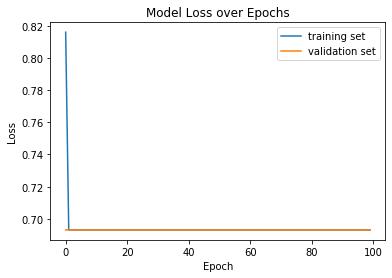

In [134]:

plt.figure()
plt.plot(model111.history['loss'])
plt.plot(model111.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])